# Clustering using Zillow Data

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# general
import pandas as pd
import numpy as np


# explore/ stat
import scipy.stats as stats

# visuals
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D



# default pandas decimal display formatting
pd.options.display.float_format='{:20,.2f}'.format

# support modules
from env import host, user, password
import acquire
import summarize
import prepare
import explore
import split_scale


# modeling
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans, dbscan


In [2]:
# acquire data, only retreive 261 > single residential family
# df = acquire.get_zillow_data().set_index("parcelid")
df = pd.read_csv('query_result.csv').set_index("parcelid")

In [3]:
# remove unit counts of two and three
df = df [(df.unitcnt != 2) | (df.unitcnt != 3)]
df['age'] = 2017 - df.yearbuilt
df.loc[:,'latitude'] = df.loc[:,'latitude']/1e6
df.loc[:,'longitude'] = df.loc[:,'longitude']/1e6
df['transactiondate'] = pd.DatetimeIndex(df['transactiondate']).month

,num_rows_missing,pct_rows_missing
finishedsquarefeet15,52169,1.00
buildingclasstypeid,52169,1.00
buildingclassdesc,52169,1.00
finishedsquarefeet13,52169,1.00
storytypeid,52122,1.00
storydesc,52122,1.00
basementsqft,52122,1.00
yardbuildingsqft26,52106,1.00
architecturalstyletypeid,52099,1.00
architecturalstyledesc,52099,1.00


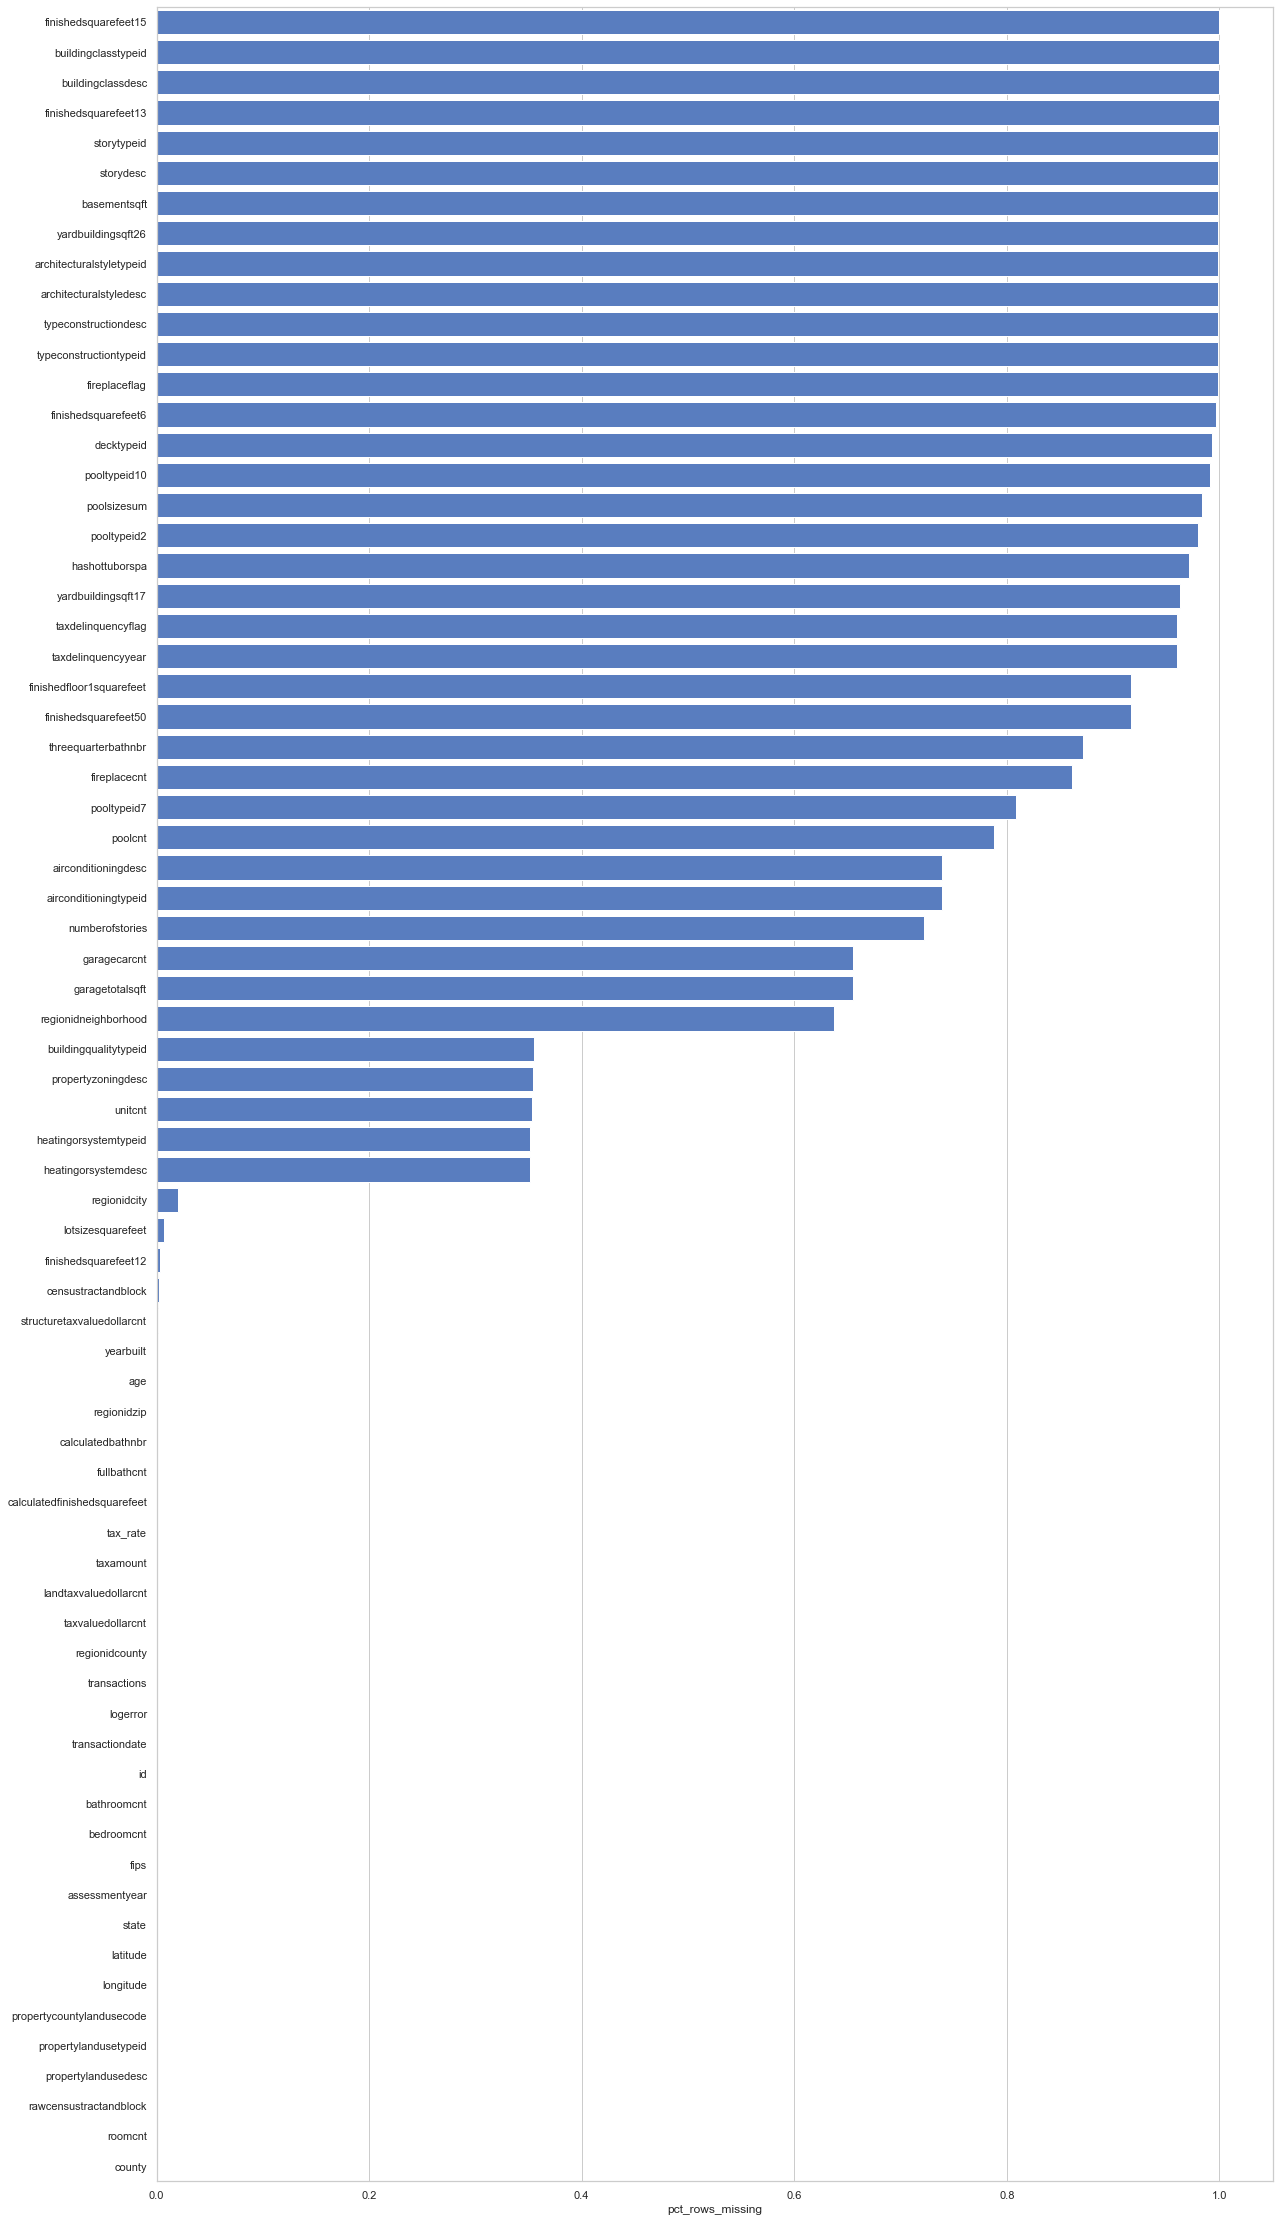

In [4]:
summarize.nulls_by_col(df)

In [5]:
summarize.nulls_by_row(df)

,num_cols_missing,pct_cols_missing,parcelid
0,23,31.944444444444443,2
1,24,33.33333333333333,12
2,25,34.72222222222222,11
3,26,36.11111111111111,30
4,27,37.5,177
5,28,38.88888888888889,388
6,29,40.27777777777778,2525
7,30,41.66666666666667,2195
8,31,43.05555555555556,5985
9,32,44.44444444444444,8882


In [6]:
summarize.df_summary(df)

--- Shape: (52169, 72)
--- Info
<class 'pandas.core.frame.DataFrame'>
Int64Index: 52169 entries, 17052889 to 14447871
Data columns (total 72 columns):
county                          52169 non-null object
tax_rate                        52164 non-null float64
id                              52169 non-null int64
airconditioningtypeid           13605 non-null float64
airconditioningdesc             13605 non-null object
architecturalstyletypeid        70 non-null float64
architecturalstyledesc          70 non-null object
basementsqft                    47 non-null float64
bathroomcnt                     52169 non-null float64
bedroomcnt                      52169 non-null int64
buildingclasstypeid             0 non-null float64
buildingclassdesc               0 non-null float64
buildingqualitytypeid           33628 non-null float64
calculatedbathnbr               52153 non-null float64
calculatedfinishedsquarefeet    52161 non-null float64
decktypeid                      387 non-null flo

 2.00    20676
 7.00    12514
 6.00      517
20.00       85
13.00       16
 1.00        7
18.00        6
10.00        2
24.00        1
Name: heatingorsystemtypeid, dtype: int64
heatingorsystemdesc:
Central       20676
Floor/Wall    12514
Forced air      517
Solar            85
None             16
Baseboard         7
Radiant           6
Gravity           2
Yes               1
Name: heatingorsystemdesc, dtype: int64
latitude:
(33.338, 33.488]      753
(33.488, 33.636]     3203
(33.636, 33.784]     6059
(33.784, 33.932]    10912
(33.932, 34.08]      9002
(34.08, 34.228]     12404
(34.228, 34.375]     4596
(34.375, 34.523]     1816
(34.523, 34.671]     2183
(34.671, 34.819]     1241
Name: latitude, dtype: int64
longitude:
(-119.47800000000001, -119.283]      158
(-119.283, -119.091]                1291
(-119.091, -118.899]                1050
(-118.899, -118.707]                1776
(-118.707, -118.515]                3838
(-118.515, -118.323]                9297
(-118.323, -118.131]      

(0.861, 14.8]      3057
(14.8, 28.6]       5912
(28.6, 42.4]       6940
(42.4, 56.2]      10198
(56.2, 70.0]      16886
(70.0, 83.8]       3879
(83.8, 97.6]       4052
(97.6, 111.4]      1017
(111.4, 125.2]      166
(125.2, 139.0]       22
Name: age, dtype: int64
None


**This function deals with missing values in the columns and the rows. If a row has more than 50% nulls, they will be removed. If a columns has more than 75% nulls, they will be removed.**

In [7]:
# original shape
df.shape

(52169, 72)

In [8]:
df = prepare.handle_missing_values(df, prop_required_column = .5, prop_required_row = .75)

**Takeaway** Removed 39 columns with over 50% rows missing and over 75% columns missing

The following columns will need imputation.

In [9]:
summarize.report_remain_nulls_by_col(df, 1)

,num_rows_missing,pct_rows_missing
tax_rate,5,0.00
buildingqualitytypeid,18540,0.36
calculatedbathnbr,15,0.00
calculatedfinishedsquarefeet,7,0.00
finishedsquarefeet12,165,0.00
fullbathcnt,15,0.00
heatingorsystemtypeid,18344,0.35
heatingorsystemdesc,18344,0.35
lotsizesquarefeet,354,0.01
propertyzoningdesc,18478,0.35


In [10]:
# bathroomcnt has no null but calculatedbathnbr does
# unsure about how calculatedbathnbr weight was determined
# drop calculatedbathnbr
print((df.bathroomcnt != df.calculatedbathnbr).sum())

15


In [11]:
# calculatedfinishedsquarefeet with way less nulls than finishedsquarefeet12
# drop finishedsquarefeet12

In [12]:
# calculatedfinishedsquarefeet with way less nulls than finishedsquarefeet12
# drop finishedsquarefeet12
df = df.drop(columns = ['propertycountylandusecode','fips','assessmentyear', 'regionidcounty','yearbuilt','propertylandusedesc','propertylandusetypeid','fullbathcnt','state','calculatedbathnbr','id','finishedsquarefeet12', 'buildingqualitytypeid', 'heatingorsystemtypeid', 'heatingorsystemdesc', 'propertyzoningdesc', 'propertyzoningdesc', 'unitcnt'])

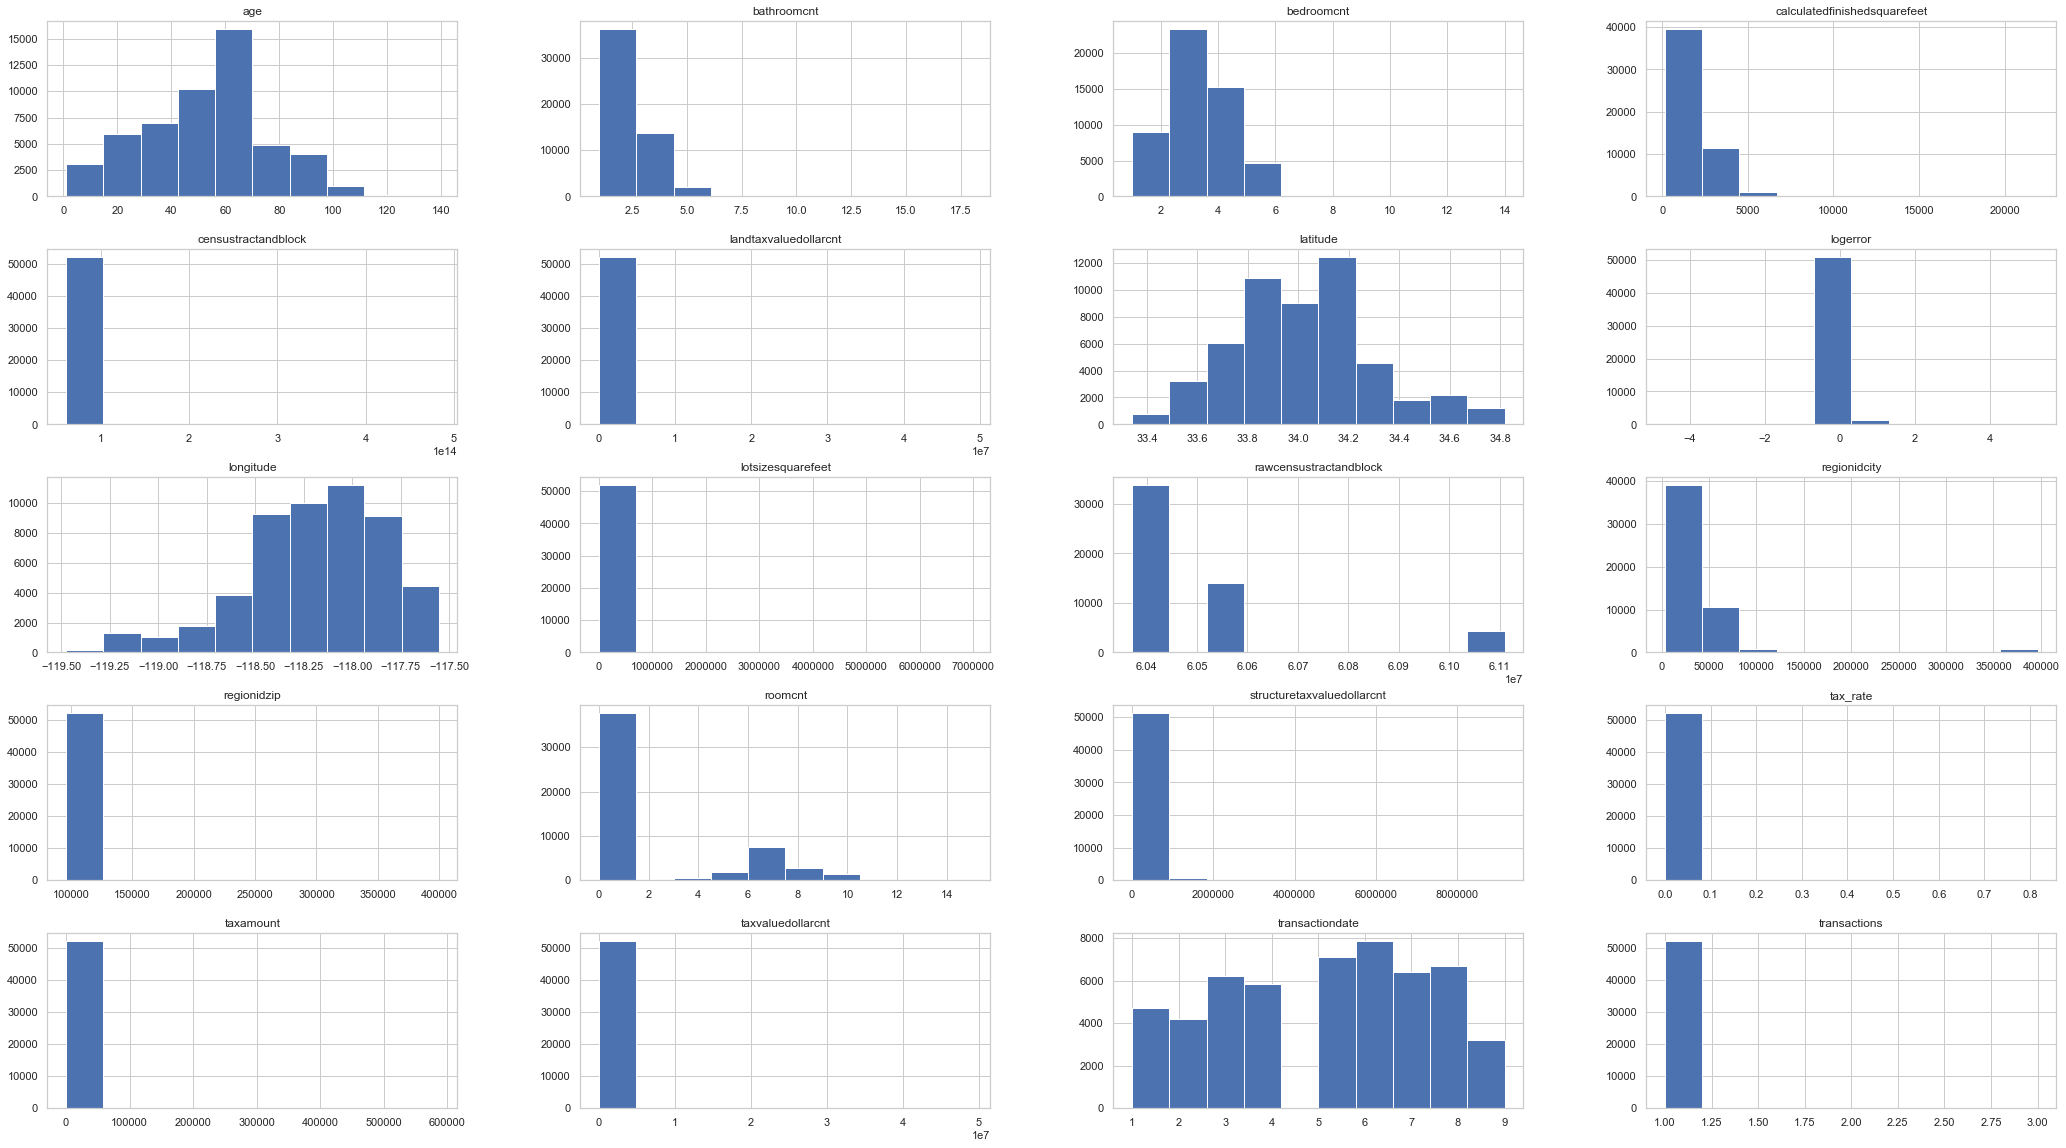

In [13]:
df.hist(figsize=(36,20))
plt.savefig('All_Data.png')

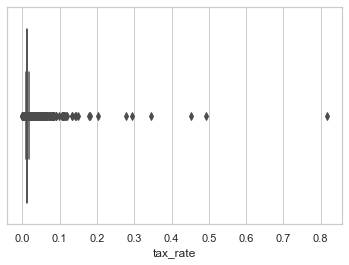

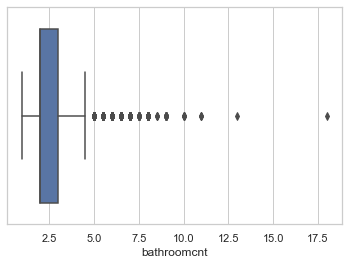

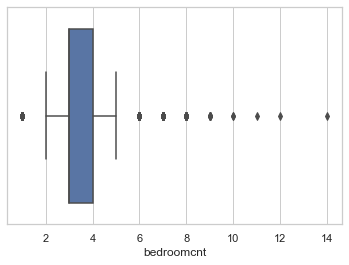

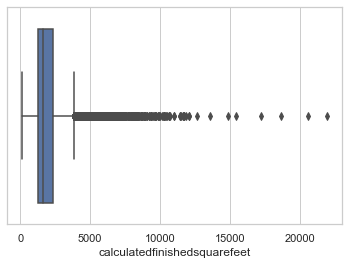

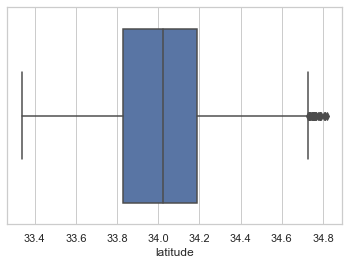

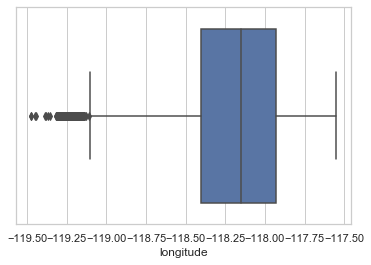

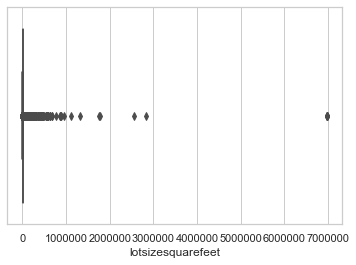

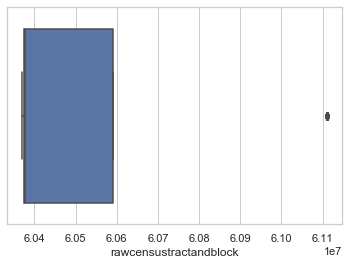

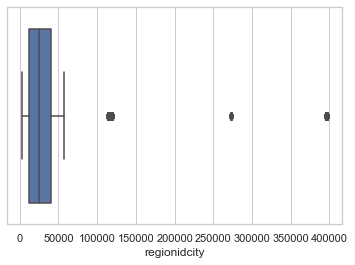

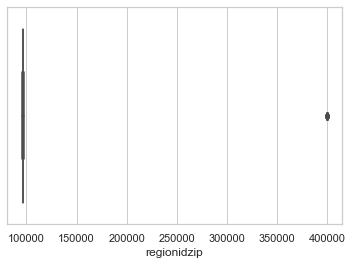

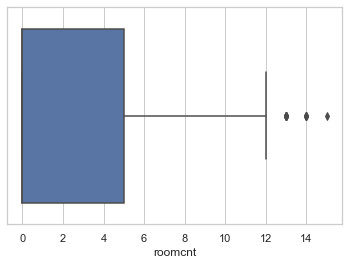

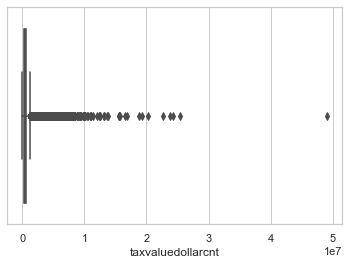

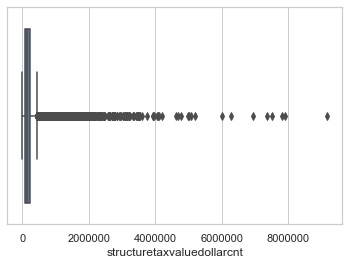

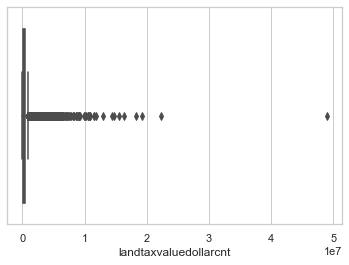

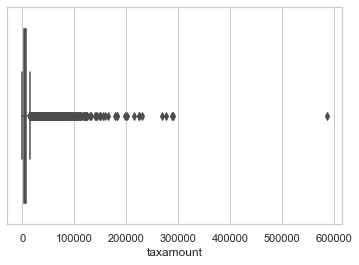

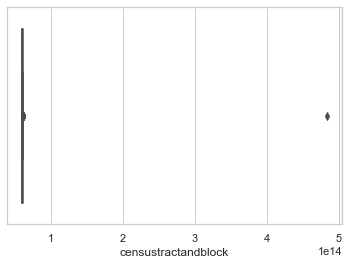

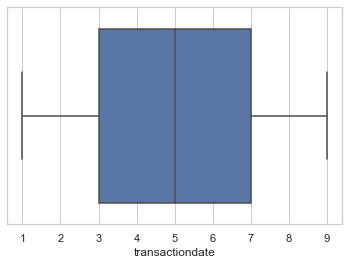

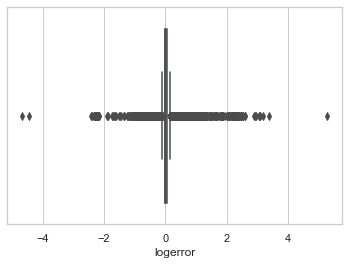

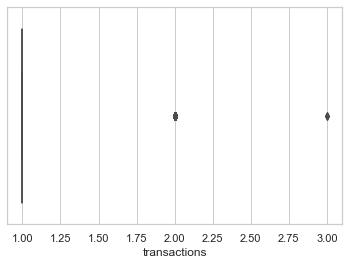

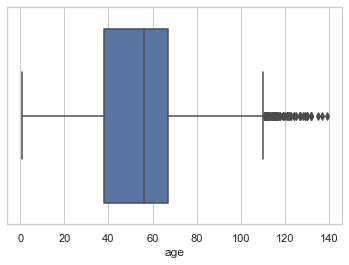

In [14]:
#visualize outliers
explore.df_feature_box(df)

In [15]:
# remove outlier
col_out = ["tax_rate", "bathroomcnt", "bedroomcnt","calculatedfinishedsquarefeet", "lotsizesquarefeet", "roomcnt", "taxamount"]
df = prepare.remove_outliers_iqr(df, col_out)

In [16]:
df = df[['county','latitude', 'longitude','regionidcity','regionidzip',\
         'rawcensustractandblock','censustractandblock',\
         'bathroomcnt', 'bedroomcnt','roomcnt',\
         'calculatedfinishedsquarefeet','lotsizesquarefeet',\
        'tax_rate','taxvaluedollarcnt',\
       'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount',\
        'transactiondate','age','transactions','logerror']]

**Split into train/ test** train_size = 0.8, random_state = 123

In [17]:
train, test = prepare.split_my_data(df)

In [18]:
col_impute_mean = ['tax_rate', 'calculatedfinishedsquarefeet', 'lotsizesquarefeet', 
                   'taxvaluedollarcnt', 'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount']

col_impute_mode = ['regionidcity', 'regionidzip','censustractandblock']

In [19]:
train, test = prepare.impute(train, test, "mean", col_impute_mean)
train, test = prepare.impute(train, test, "most_frequent", col_impute_mode)

In [20]:
train["transactions"] = train.transactions.astype("float")

train["bedroomcnt"] = train.bedroomcnt.astype("int")
train["roomcnt"] = train.roomcnt.astype("int")

train["regionidcity"] = train.regionidcity.astype("object")
train["regionidzip"] = train.regionidzip.astype("object")


test["transactions"] = test.transactions.astype("float")

test["bedroomcnt"] = test.bedroomcnt.astype("int")
test["roomcnt"] = test.roomcnt.astype("int")

test["regionidcity"] = test.regionidcity.astype("object")
test["regionidzip"] = test.regionidzip.astype("object")


In [21]:
mm = ['latitude','longitude']
std = ['bathroomcnt','bedroomcnt','calculatedfinishedsquarefeet','lotsizesquarefeet','age']

In [22]:
scaler, train_scaled, test_scaled = split_scale.standard_scaler\
(train[['bathroomcnt','bedroomcnt','calculatedfinishedsquarefeet','lotsizesquarefeet','age']],\
test[['bathroomcnt','bedroomcnt','calculatedfinishedsquarefeet','lotsizesquarefeet','age']])


In [23]:
train1 = train.drop(columns = std)
train1 = train1.join(train_scaled)
test1 = test.drop(columns = std)
test1 = test1.join(test_scaled)

In [24]:
scaler, train_scaled, test_scaled = split_scale.min_max_scaler\
(train[['latitude','longitude']], test[['latitude','longitude']])

In [25]:
train1 = train1.drop(columns = mm)
train1 = train1.join(train_scaled)
test1 = test1.drop(columns = mm)
test1 = test1.join(test_scaled)

In [26]:
# obtain clusters for modeling
from sklearn.cluster import KMeans, dbscan

kmeans = KMeans(n_clusters=5, random_state = 123).fit(train1[['longitude', 'latitude']])
train1['cluster'] = kmeans.predict(train1[['longitude', 'latitude']])

cluster_0 = train1[train1.cluster == 0]
cluster_1 = train1[train1.cluster == 1]
cluster_2 = train1[train1.cluster == 2]
cluster_3 = train1[train1.cluster == 3]
cluster_4 = train1[train1.cluster == 4]

In [27]:
def encode(train, test, col_name):
    from sklearn.preprocessing import LabelEncoder
    
    # Integer Encoding
    int_encoder = LabelEncoder()
    train[col_name] = int_encoder.fit_transform(train[col_name])
    test[col_name] = int_encoder.transform(test[col_name])
    
    return train, test

In [28]:
train1, test1 = encode(train1, test1, 'county')

In [29]:
train1['age'] = train1['age'].astype(int)
train1['lotsizesquarefeet'] = train1['lotsizesquarefeet'].astype(int)
train1['calculatedfinishedsquarefeet'] = train1['calculatedfinishedsquarefeet'].astype(int)
train1['bedroomcnt'] = train1['bedroomcnt'].astype(int)
train1['bathroomcnt'] = train1['bathroomcnt'].astype(int)

In [30]:
train1['transactiondate'] = pd.DatetimeIndex(train1['transactiondate']).month

In [31]:
# Decision Tree Regressor
x_train1 = train1[['county', 'age', 'cluster', 'transactiondate', 'bedroomcnt', 'bathroomcnt', 'lotsizesquarefeet', 'calculatedfinishedsquarefeet']]
y_train1 = train1[['logerror']]
#x = test1[['county', 'age', 'cluster', 'transactiondate', 'lotsizesquarefeet', 'calculatedfinishedsquarefeet', 'bedroomcnt', 'bathroomcnt']]
#y = test1[['logerror']]

In [32]:
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(max_depth=10, random_state=123)
regressor.fit(x_train1, y_train1)

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=123, splitter='best')

In [33]:
y_pred = regressor.predict(x_train1)
y_pred[0:5]

array([ 0.01694974,  0.0054454 , -0.00520695,  0.01694974,  0.00591302])

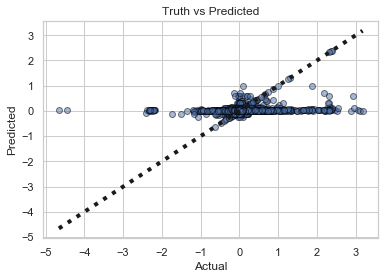

In [34]:
from sklearn.model_selection import cross_val_predict

fig, ax = plt.subplots()
ax.scatter(y_train1, y_pred, edgecolors=(0, 0, 0), alpha=.5)
ax.plot([y_train1.min(), y_train1.max()], [y_train1.min(), y_train1.max()], 'k:', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Truth vs Predicted")
plt.show()

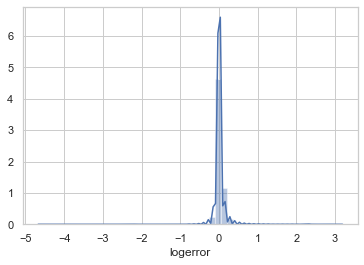

In [35]:
# overall logerror distribution 
sns.distplot(df.logerror)

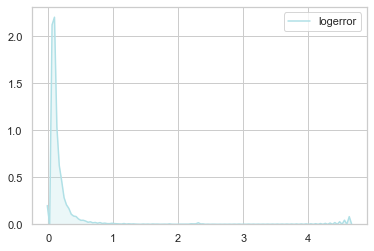

In [36]:
sns.kdeplot(df.logerror.abs(), shade=True, color="powderblue")
plt.show()

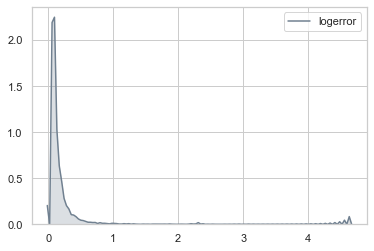

In [37]:
sns.kdeplot(train.logerror.abs(), shade=True, color="slategray")

**Explore numeric variables**

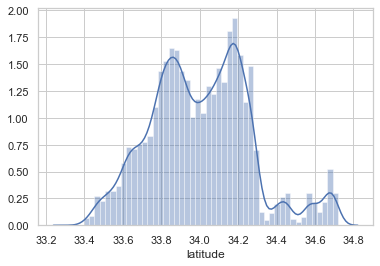

(56.8, 70.5]      11733
(43.1, 56.8]       7082
(29.4, 43.1]       4621
(15.7, 29.4]       3688
(84.2, 97.9]       2750
(70.5, 84.2]       2707
(1.862, 15.7]      1645
(97.9, 111.6]       725
(111.6, 125.3]      122
(125.3, 139.0]       14
Name: age, dtype: int64


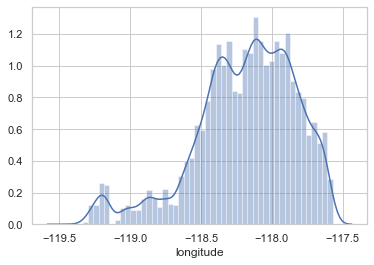

(56.8, 70.5]      11733
(43.1, 56.8]       7082
(29.4, 43.1]       4621
(15.7, 29.4]       3688
(84.2, 97.9]       2750
(70.5, 84.2]       2707
(1.862, 15.7]      1645
(97.9, 111.6]       725
(111.6, 125.3]      122
(125.3, 139.0]       14
Name: age, dtype: int64


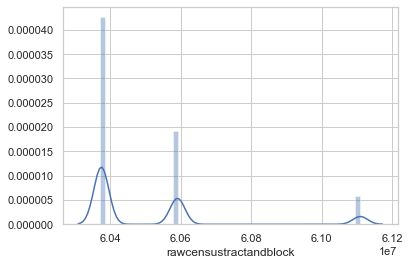

(56.8, 70.5]      11733
(43.1, 56.8]       7082
(29.4, 43.1]       4621
(15.7, 29.4]       3688
(84.2, 97.9]       2750
(70.5, 84.2]       2707
(1.862, 15.7]      1645
(97.9, 111.6]       725
(111.6, 125.3]      122
(125.3, 139.0]       14
Name: age, dtype: int64


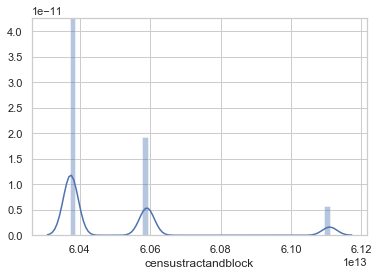

(56.8, 70.5]      11733
(43.1, 56.8]       7082
(29.4, 43.1]       4621
(15.7, 29.4]       3688
(84.2, 97.9]       2750
(70.5, 84.2]       2707
(1.862, 15.7]      1645
(97.9, 111.6]       725
(111.6, 125.3]      122
(125.3, 139.0]       14
Name: age, dtype: int64


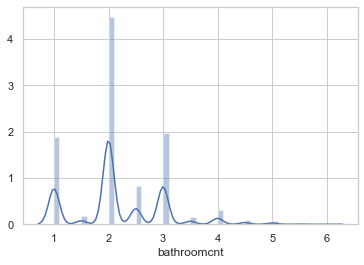

(56.8, 70.5]      11733
(43.1, 56.8]       7082
(29.4, 43.1]       4621
(15.7, 29.4]       3688
(84.2, 97.9]       2750
(70.5, 84.2]       2707
(1.862, 15.7]      1645
(97.9, 111.6]       725
(111.6, 125.3]      122
(125.3, 139.0]       14
Name: age, dtype: int64


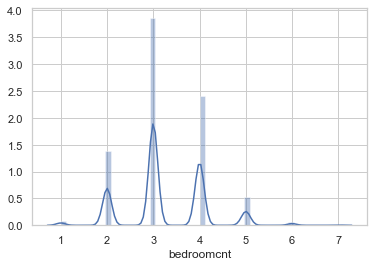

3    16223
4    10154
2     5822
5     2207
1      375
6      267
7       39
Name: bedroomcnt, dtype: int64


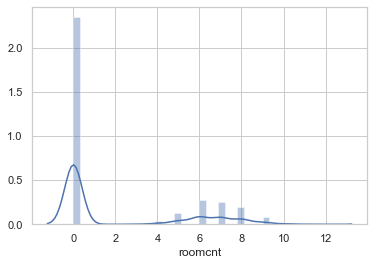

(56.8, 70.5]      11733
(43.1, 56.8]       7082
(29.4, 43.1]       4621
(15.7, 29.4]       3688
(84.2, 97.9]       2750
(70.5, 84.2]       2707
(1.862, 15.7]      1645
(97.9, 111.6]       725
(111.6, 125.3]      122
(125.3, 139.0]       14
Name: age, dtype: int64


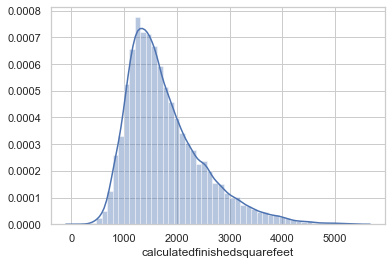

(56.8, 70.5]      11733
(43.1, 56.8]       7082
(29.4, 43.1]       4621
(15.7, 29.4]       3688
(84.2, 97.9]       2750
(70.5, 84.2]       2707
(1.862, 15.7]      1645
(97.9, 111.6]       725
(111.6, 125.3]      122
(125.3, 139.0]       14
Name: age, dtype: int64


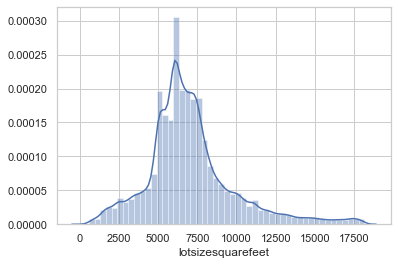

(56.8, 70.5]      11733
(43.1, 56.8]       7082
(29.4, 43.1]       4621
(15.7, 29.4]       3688
(84.2, 97.9]       2750
(70.5, 84.2]       2707
(1.862, 15.7]      1645
(97.9, 111.6]       725
(111.6, 125.3]      122
(125.3, 139.0]       14
Name: age, dtype: int64


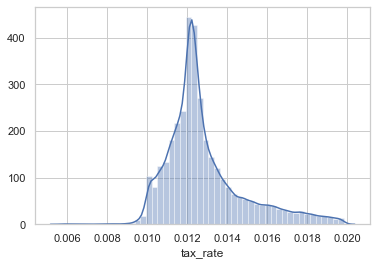

(56.8, 70.5]      11733
(43.1, 56.8]       7082
(29.4, 43.1]       4621
(15.7, 29.4]       3688
(84.2, 97.9]       2750
(70.5, 84.2]       2707
(1.862, 15.7]      1645
(97.9, 111.6]       725
(111.6, 125.3]      122
(125.3, 139.0]       14
Name: age, dtype: int64


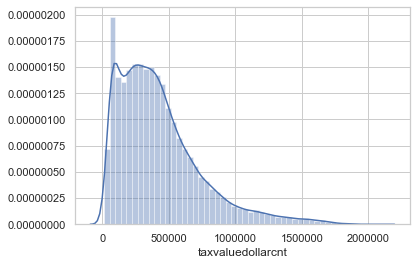

(56.8, 70.5]      11733
(43.1, 56.8]       7082
(29.4, 43.1]       4621
(15.7, 29.4]       3688
(84.2, 97.9]       2750
(70.5, 84.2]       2707
(1.862, 15.7]      1645
(97.9, 111.6]       725
(111.6, 125.3]      122
(125.3, 139.0]       14
Name: age, dtype: int64


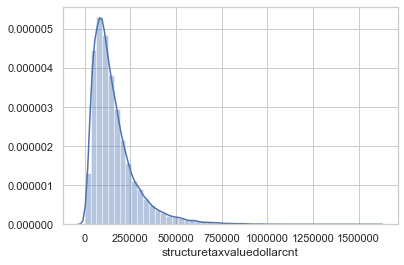

(56.8, 70.5]      11733
(43.1, 56.8]       7082
(29.4, 43.1]       4621
(15.7, 29.4]       3688
(84.2, 97.9]       2750
(70.5, 84.2]       2707
(1.862, 15.7]      1645
(97.9, 111.6]       725
(111.6, 125.3]      122
(125.3, 139.0]       14
Name: age, dtype: int64


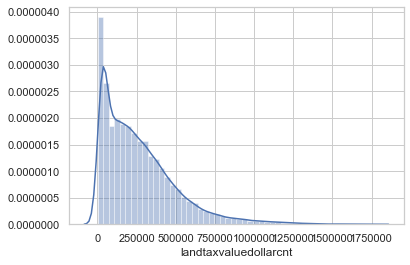

(56.8, 70.5]      11733
(43.1, 56.8]       7082
(29.4, 43.1]       4621
(15.7, 29.4]       3688
(84.2, 97.9]       2750
(70.5, 84.2]       2707
(1.862, 15.7]      1645
(97.9, 111.6]       725
(111.6, 125.3]      122
(125.3, 139.0]       14
Name: age, dtype: int64


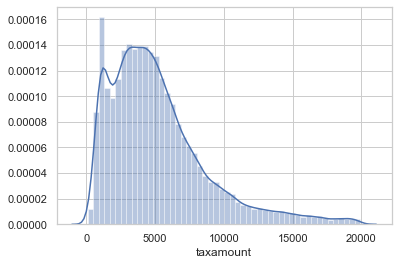

(56.8, 70.5]      11733
(43.1, 56.8]       7082
(29.4, 43.1]       4621
(15.7, 29.4]       3688
(84.2, 97.9]       2750
(70.5, 84.2]       2707
(1.862, 15.7]      1645
(97.9, 111.6]       725
(111.6, 125.3]      122
(125.3, 139.0]       14
Name: age, dtype: int64


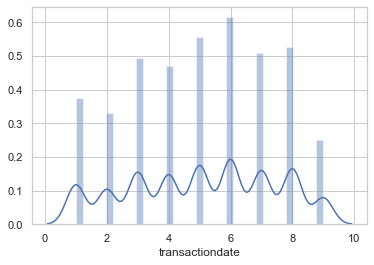

6    5231
5    4737
8    4476
7    4322
3    4195
4    3994
1    3190
2    2806
9    2136
Name: transactiondate, dtype: int64


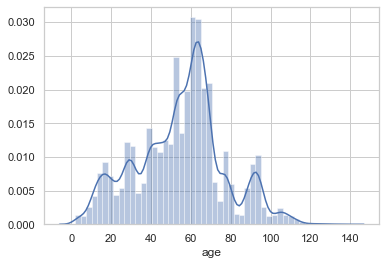

(56.8, 70.5]      11733
(43.1, 56.8]       7082
(29.4, 43.1]       4621
(15.7, 29.4]       3688
(84.2, 97.9]       2750
(70.5, 84.2]       2707
(1.862, 15.7]      1645
(97.9, 111.6]       725
(111.6, 125.3]      122
(125.3, 139.0]       14
Name: age, dtype: int64


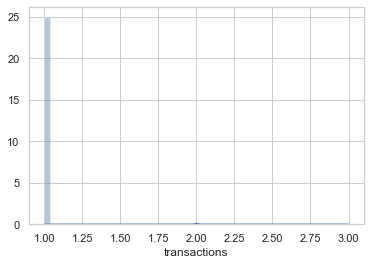

1.00    35013
2.00       73
3.00        1
Name: transactions, dtype: int64


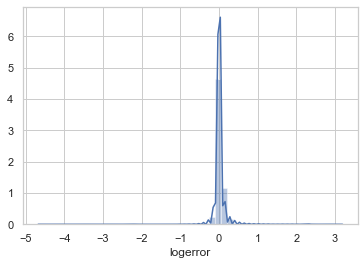

(56.8, 70.5]      11733
(43.1, 56.8]       7082
(29.4, 43.1]       4621
(15.7, 29.4]       3688
(84.2, 97.9]       2750
(70.5, 84.2]       2707
(1.862, 15.7]      1645
(97.9, 111.6]       725
(111.6, 125.3]      122
(125.3, 139.0]       14
Name: age, dtype: int64


In [38]:
num_plot = list(train.select_dtypes(np.number).columns)
for n in num_plot:
    sns.distplot(train[n].dropna())
    plt.show()
    if train[n].nunique() > 10:
        print(train.age.value_counts(bins = 10))
    else:
        print(train[n].value_counts())

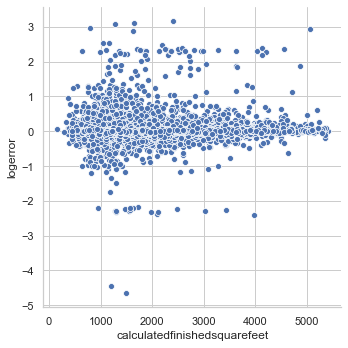

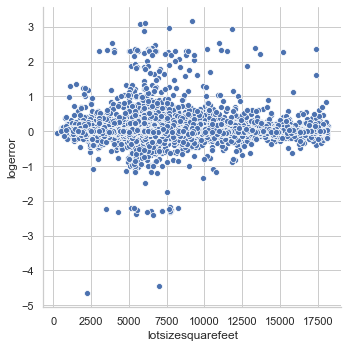

In [39]:
# ridge regression & 'calculatedfinishedsquarefeet' may predict logerror well?
sns.relplot('calculatedfinishedsquarefeet', 'logerror', data = train)
sns.relplot('lotsizesquarefeet', 'logerror', data = train)    
plt.show()

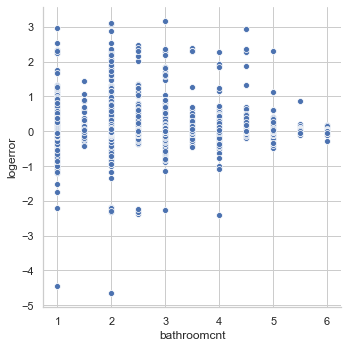

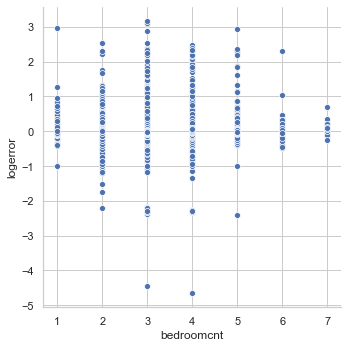

In [40]:
sns.relplot('bathroomcnt', 'logerror', data = train)
sns.relplot('bedroomcnt', 'logerror', data = train)
plt.show()

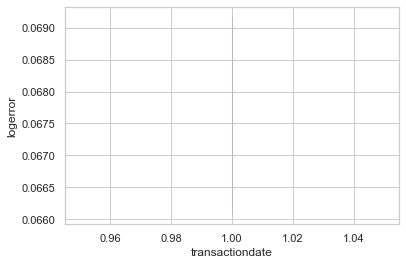

In [41]:
train['transactiondate'] = pd.DatetimeIndex(train['transactiondate']).month
sns.lineplot(train.transactiondate, train.logerror.abs())

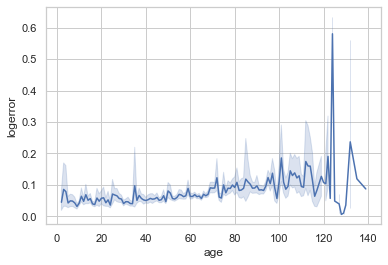

In [42]:
sns.lineplot(x = train.age, y = train.logerror.abs())

Text(0, 0.5, 'inertia')

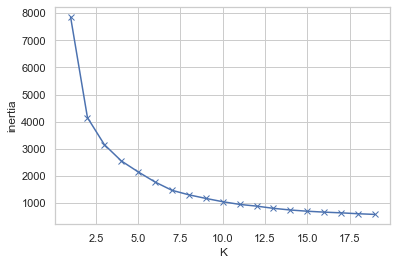

In [43]:
subset = train[['longitude', 'latitude','logerror']]

k_values = []
inertias = []

for k in range(1, 20):
    kmeans = KMeans(n_clusters=k).fit(subset)
    inertias.append(kmeans.inertia_)
    k_values.append(k)

plt.plot(k_values, inertias, marker='x')
plt.xlabel('K')
plt.ylabel('inertia')

In [44]:
train['logerror_abs'] = train.logerror.abs()
subset = train[['longitude', 'latitude','logerror']]
kmeans = KMeans(n_clusters=7).fit(subset)
centers = pd.DataFrame(kmeans.cluster_centers_, columns=subset.columns)

[Text(0.5, 0, 'Logerror'), Text(0.5, 0, 'Latitude'), Text(0.5, 0, 'Longitude')]

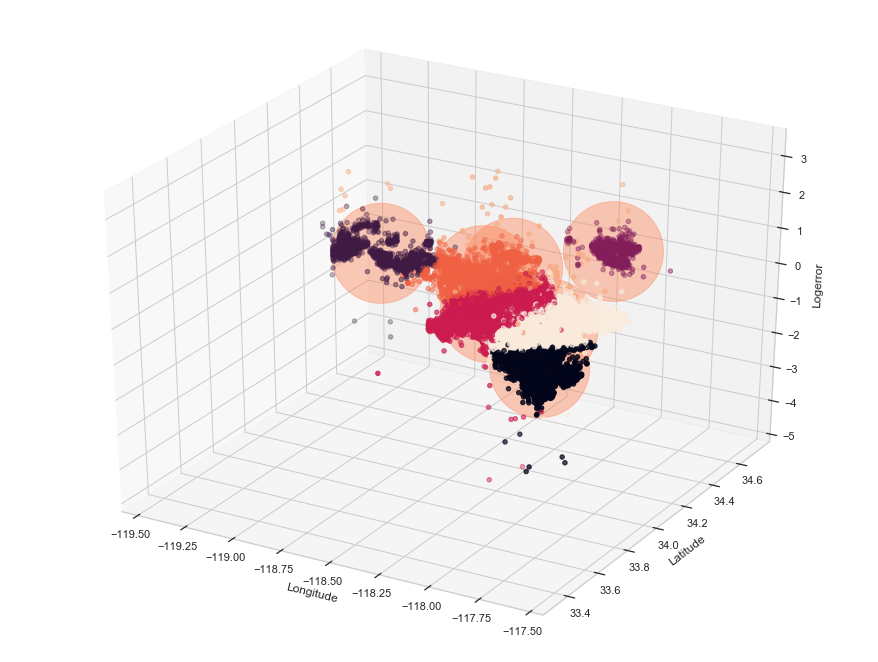

In [45]:
fig = plt.figure(figsize=(12, 9))
ax = Axes3D(fig)

ax.scatter(train.longitude, train.latitude, train.logerror, c=kmeans.labels_)
ax.scatter(centers.longitude, centers.latitude, centers.logerror, c='coral', s=10000, alpha=.4)
ax.set(xlabel='Longitude', ylabel='Latitude', zlabel='Logerror')

In [61]:
subset = train[['longitude', 'latitude','taxamount']]
kmeans = KMeans(n_clusters=4).fit(subset)
centers = pd.DataFrame(kmeans.cluster_centers_, columns=subset.columns)

[Text(0.5, 0, 'Taxamount'),
 Text(0.5, 0, 'Latitude'),
 Text(0.5, 0, 'Longitude')]

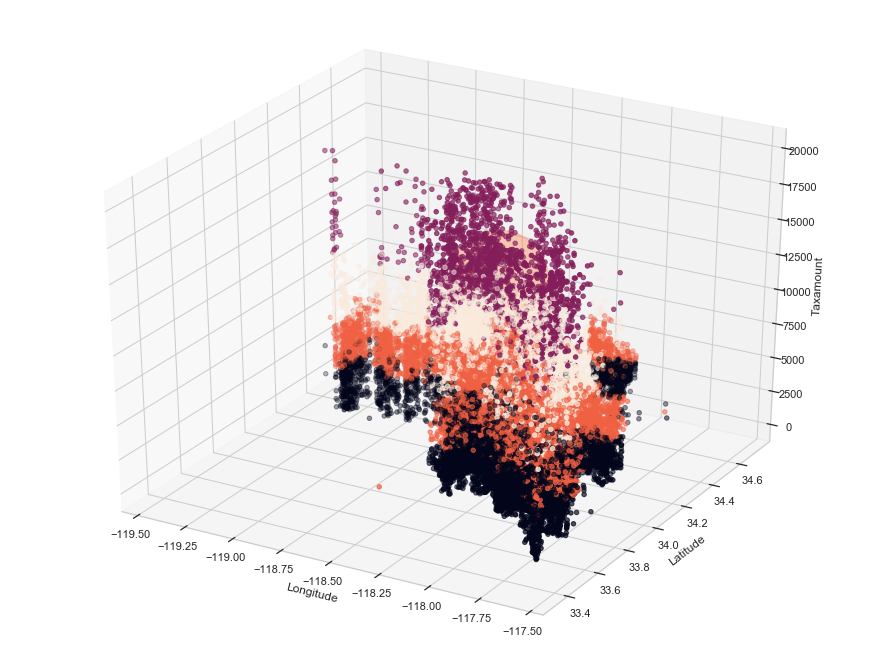

In [47]:
fig = plt.figure(figsize=(12, 9))
ax = Axes3D(fig)

ax.scatter(train.longitude, train.latitude, train.taxamount, c=kmeans.labels_)
ax.scatter(centers.longitude, centers.latitude, centers.taxamount, c='coral', s=10000, alpha=.4)
ax.set(xlabel='Longitude', ylabel='Latitude', zlabel='Taxamount')

In [64]:
def k_cluster_3d(train, x, y, z, n):
    """
    Displays 3d plot of clusters.
    """
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(train)
    labels = kmeans.labels_

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(train[x], train[y], train[z], c=labels, edgecolors="grey",alpha=.5)
    ax.set(xticklabels=[], yticklabels=[], zticklabels=[])
    ax.set(xlabel=x, ylabel=y, zlabel=z)
    ax.xaxis.labelpad=-5
    ax.yaxis.labelpad=-5
    ax.zaxis.labelpad=-5
    plt.show()

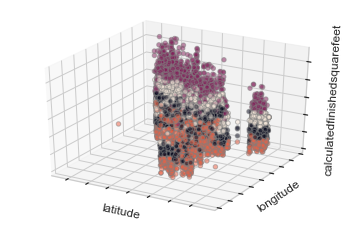

In [65]:
k_cluster_3d(train[["latitude","longitude","calculatedfinishedsquarefeet"]], "latitude","longitude","calculatedfinishedsquarefeet",4)

In [68]:
df.age.unique()

array([ 50.,  13.,  48.,  60.,  39.,  52.,  30.,  28.,  90.,  22.,  67.,
        40.,  61.,  64.,  47.,  11.,  38.,  58.,   5.,  53.,  45.,  56.,
        65.,   7.,  57.,   4.,  34.,  55.,  36.,  51.,  42.,  16.,  43.,
        41.,  37.,  31.,  62.,  71.,  14.,  15.,  54.,  95.,  18.,  78.,
       109.,  73.,  97.,  69.,  76.,  89., 116.,  59.,  26.,  33., 100.,
        77.,  79.,  80.,  63.,  94.,  32.,  46.,  70.,  29.,  88.,  87.,
        82., 105.,  66.,  86.,  19., 115.,  27.,  49., 104.,  68.,  75.,
        91., 122.,  93.,  24.,   3.,  92.,  81.,  74.,  85., 107.,  23.,
        20.,  nan,   9.,  96.,  10.,  12.,  17.,  44.,  21.,  83.,  25.,
        72., 103.,   8.,  84., 132., 108., 106.,  99.,  98., 102.,   6.,
        35., 114., 101., 112., 111., 117., 110., 113., 121., 128., 129.,
         2., 127., 124., 120., 125., 130., 139., 119., 135., 123.])

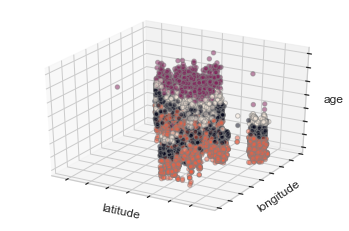

In [66]:
k_cluster_3d(train[["latitude","longitude","age"]], "latitude","longitude","age",4)

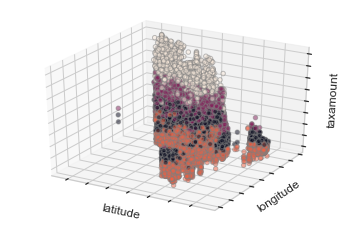

In [49]:
k_cluster_3d(df[["latitude","longitude","taxamount"]], "latitude","longitude","taxamount",4)

In [54]:
k_cluster_3d(df[["latitude","longitude","taxamount"]], "latitude","longitude","taxamount",4)

In [53]:
estimators = [('2 Clusters', KMeans(n_clusters=2)),
              ('3 Clusters', KMeans(n_clusters=3))]

fig, axs = plt.subplots(1, 2, figsize=(14, 6), subplot_kw={'projection': '3d'})

for ax, (title, kmeans) in zip(axs, estimators):
    # fit the kmeans object
    kmeans.fit(train_ex_loc[["logerror","latitude","countyid"]])

    labels = kmeans.labels_

    ax.scatter(train_ex_loc.countyid, 
               train_ex_loc.latitude, 
               train_ex_loc.logerror,
               c=labels.astype(np.float), edgecolor='k')
    ax.set(xticklabels=[], yticklabels=[], zticklabels=[])
    ax.set(xlabel='countyid', ylabel='latitude', zlabel='logerror')

ValueError: could not convert string to float: 'Los Angeles'

In [ ]:
subset = train[['longitude', 'latitude','age']]

k_values = []
inertias = []

for k in range(1, 20):
    kmeans = KMeans(n_clusters=k).fit(subset)
    inertias.append(kmeans.inertia_)
    k_values.append(k)

plt.plot(k_values, inertias, marker='x')
plt.xlabel('K')
plt.ylabel('inertia')

In [ ]:
subset = train[['longitude', 'latitude','age']]
kmeans = KMeans(n_clusters= 10).fit(subset)

centers = pd.DataFrame(kmeans.cluster_centers_, columns=subset.columns)
fig = plt.figure(figsize=(12, 9))
ax = Axes3D(fig)

ax.scatter(train.longitude, train.latitude, train.age, c=kmeans.labels_)
ax.scatter(centers.longitude, centers.latitude, centers.age, c='coral', s=10000, alpha=.4)
ax.set(xlabel='Logitude', ylabel='Latitude', zlabel='Age of House')

In [ ]:
X = train1[['longitude', 'latitude']]

kmeans = KMeans(n_clusters=5, random_state = 123).fit(X)

X['cluster'] = 'clusters ' + pd.Series(kmeans.predict(X)).astype(str)

sns.relplot(data=X, hue=kmeans.labels_, x='longitude', y='latitude')
plt.scatter(x=kmeans.cluster_centers_[:, 0], y=kmeans.cluster_centers_[:, 1], marker='x', s=200, c='black')

In [ ]:
# obtain clusters for modeling
kmeans = KMeans(n_clusters=5, random_state = 123).fit(train1[['longitude', 'latitude']])
train1['cluster'] = kmeans.predict(train1[['longitude', 'latitude']])

cluster_0 = train1[train1.cluster == 0]
cluster_1 = train1[train1.cluster == 1]
cluster_2 = train1[train1.cluster == 2]
cluster_3 = train1[train1.cluster == 3]
cluster_4 = train1[train1.cluster == 4]

In [ ]:
X = train[['regionidcity', 'logerror']]

kmeans = KMeans(n_clusters=7)
kmeans.fit(X)

X['cluster'] = 'clusters ' + pd.Series(kmeans.predict(X)).astype(str)

sns.relplot(data=X, hue=kmeans.labels_, x='regionidcity', y='logerror')
plt.scatter(x=kmeans.cluster_centers_[:, 0], y=kmeans.cluster_centers_[:, 1], marker='x', s=200, c='black')


In [ ]:
sns.scatterplot('regionidcity', "logerror", data=train)


In [69]:
def df_feature_dist(data):
    # get a list of columns where content is number
    features_num = list(df.select_dtypes(np.number).columns)
    for feature in features_num:
        sns.jointplot(feature, "logerror", data=data, kind="hex")
        plt.show()

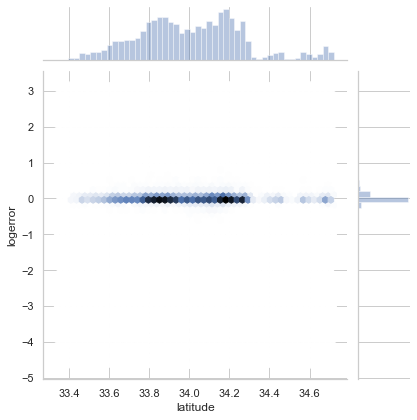

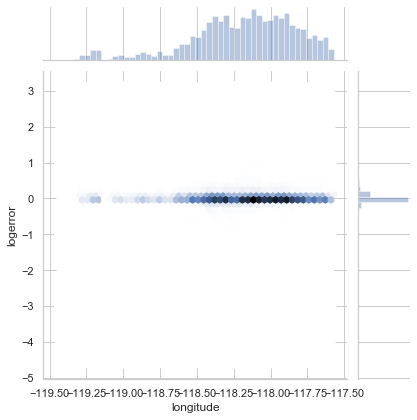

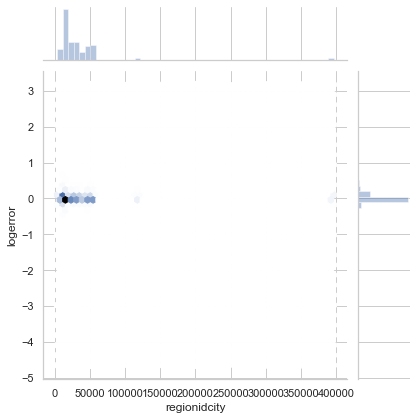

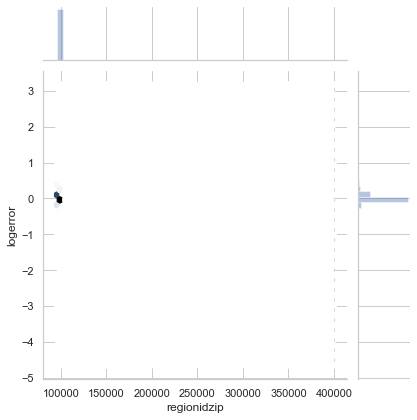

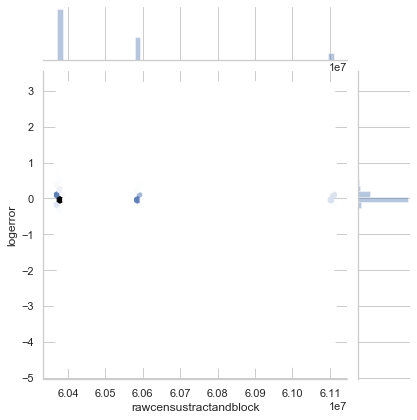

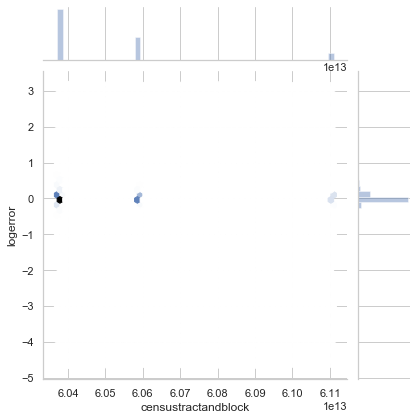

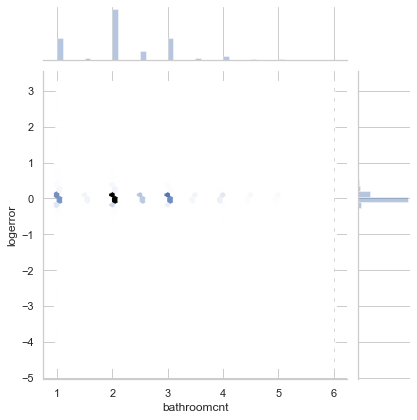

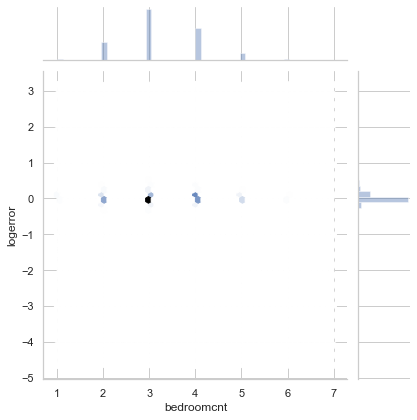

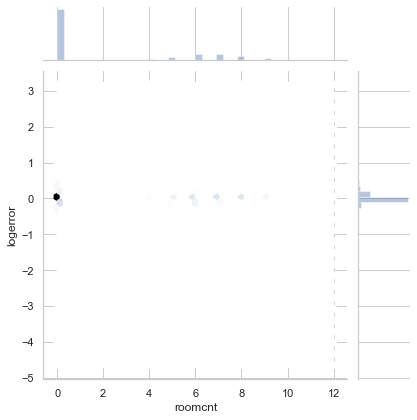

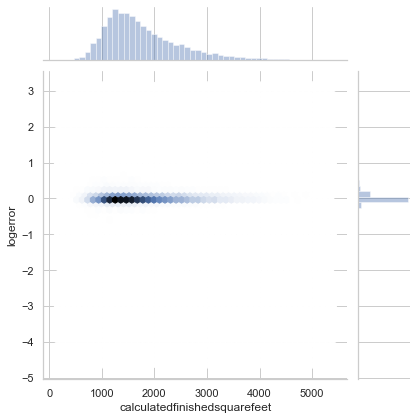

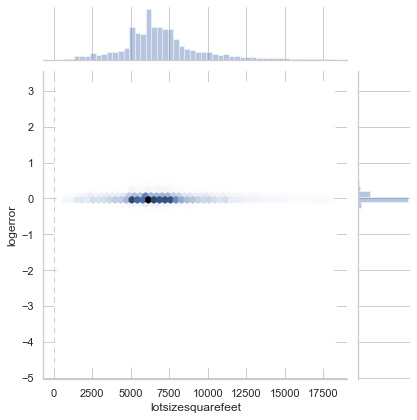

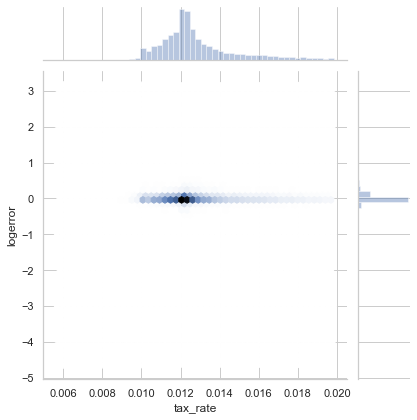

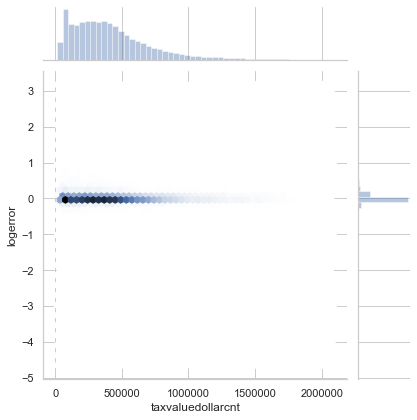

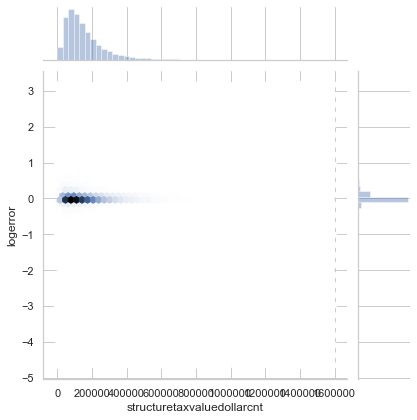

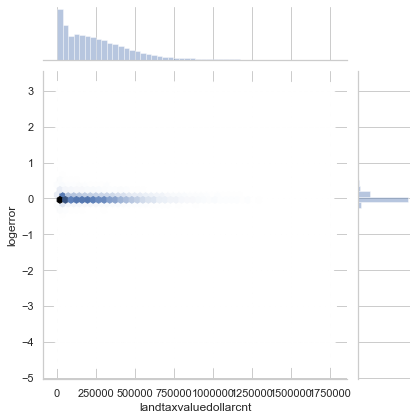

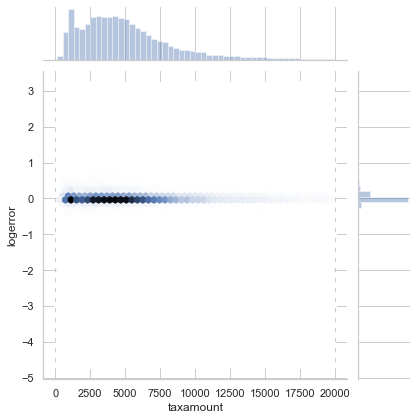

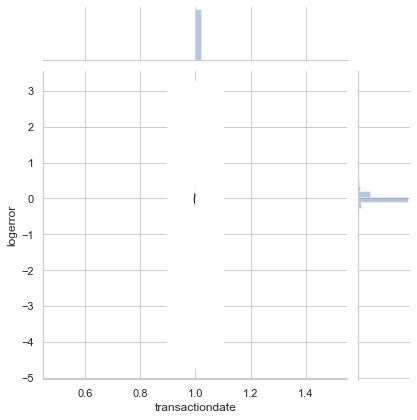

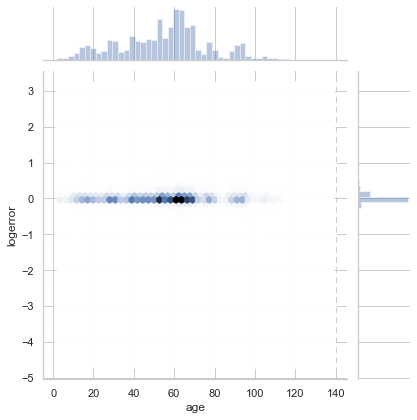

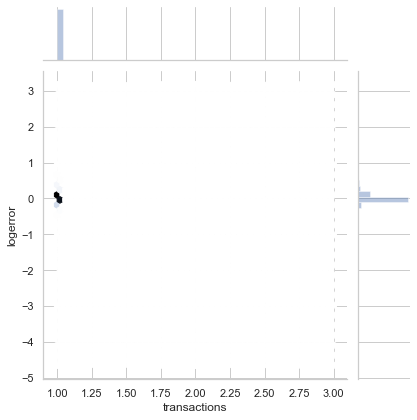

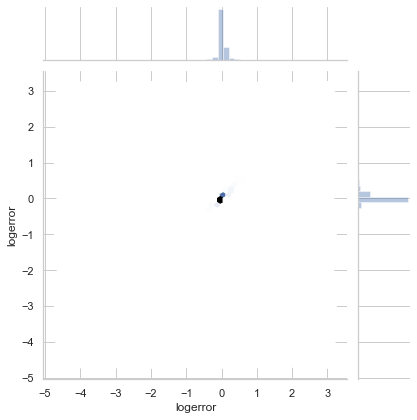

In [70]:
df_feature_dist(train)

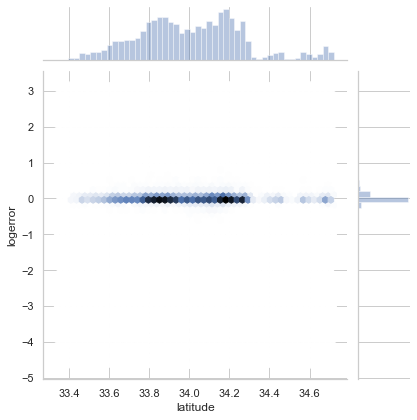

In [71]:
sns.jointplot("latitude", "logerror", data=train, kind="hex")


In [ ]:
sns.jointplot("longitude", "logerror", data=train, kind="hex")

In [ ]:
sns.scatterplot(x = 'lotsizesquarefeet', y = 'logerror', data=train, palette="Blues_d")

In [ ]:
sns.scatterplot(x = 'lotsizesquarefeet', y = 'logerror', data=train, palette="Blues_d")

In [ ]:
# ridge regression???
sns.scatterplot(x = 'calculatedfinishedsquarefeet', y = 'logerror', data=train, palette="Blues_d")

In [ ]:
# so many cities in the three counties!!!
train.regionidcity.nunique()

In [ ]:
sns.barplot(x= 'bedroomcnt', y="logerror", data=train, palette="Blues_d")

In [ ]:
sns.barplot(x= 'bathroomcnt', y="logerror", data=train, palette="Blues_d")

In [ ]:
sns.barplot(x= 'county', y="logerror", data=train, palette="Blues_d")

In [ ]:
# can delete riogionidcounty
sns.barplot(x= 'regionidcounty', y="logerror", data=train, palette="Blues_d")

In [ ]:
sns.barplot(x= 'propertycountylandusecode', y="logerror", data=train, palette="Blues_d")
plt.xticks(rotation=-80)

In [ ]:
# 'transactiondate','regionidzip', 'regionidcity' can't be object

In [ ]:
sns.barplot(x= 'regionidzip', y="logerror", data=train, palette="Blues_d")
plt.xticks(rotation=-80)

In [ ]:
sns.barplot(x= 'regionidcity', y="logerror", data=train, palette="Blues_d")

The 'heatingorsystemtypeid', 'heatingorsystemdesc' and 'propertyzoningdesc' have significantly less values than the other values, but not so much so that they were removed with the function. We will just take note of this if we need to reference that leter on.

In [ ]:
def df_feature_dist(df):
    # get a list of columns where content is number
    features_num = list(df.select_dtypes(np.number).columns)
    for feature in features_num:
        sns.distplot(df[feature].dropna())
        plt.show()

In [ ]:
df_feature_dist(df)

**NOTES ABOUT FEATURES**
- calculatedfinishedsquarefeet max = 5408 seems really big
    think twice about what does calculatedfinishedsquarefeet truly means
    
    
- lotsizesquarefeet also really big, how does that compare to calc finished?

- roomcnt, bathroomcnt, bedroomcnt

- latitude and longitude need to be processed (make normal by /10^6?)

- rawcensustractandblock, censustractandblock, regionidcity, regionidcounty , regionidzip
    how to use? what value do these col bring?

- taxvaluedollarcnt, structuretaxvaluedollarcnt, landtaxvaluedollarcnt, taxamount

- assessmentyear > double check year

- age

- transactions???

- logerror > TARGET

**Understand Zestimate**
To calculate a Zestimate, Zillow uses a sophisticated and proprietary algorithm that incorporates data from county and tax assessor records and direct feeds from hundreds of multiple listing services and brokerages. The Zestimate also incorporates a home's facts and features, which homeowners have the ability to update.

The Zestimate accounts for variables like:

Home characteristics including square footage, location or the number of bathrooms
Unique features like hardwood floors, granite countertops or a landscaped backyard
On-market data such as listing price, description, comparable homes in the area and days on the market
Off-market data — tax assessments, prior sales and other publicly available records

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df.describe())

In [ ]:
train['bnb'] = train['bathroomcnt'] + train['bedroomcnt']


In [ ]:
sns.scatterplot(x = 'bathroomcnt', y = 'logerror', data = train)


In [ ]:
sns.scatterplot(x = 'bnb', y = 'logerror', data = train)


In [ ]:
plt.figure(figsize = (11,11))
sns.barplot(x = 'bnb', y = 'logerror', data = train)


continuous vs continuous, relplot

discrete vs continuous, t-test (group pool or not pool and compare prices)

two discrete, chi-squared test, pandas crosstabs, clustering

- Longitude/latitude definitely have a correlation with log error. Used k=7 for clustering.
- Age does not appear to have a correlation with log error. Maybe drop it?
- Region city does not have a correlation with log error. They are pretty evenly spread out.
- Combine bed/bath count to create a single feature to then work with one column.
- Drop roomcnt.
- Table Census information
- Look more into transaction date, maybe treat each data as a categorical var.
- Drop assessmentyear
- Drop property county land use code, using long/lat and have county names already.
- Tax amout/ * tax dollar count relates to log error, maybe not a good feature to use -- keep in mind.
- Add back in outliers in a separate dataframe, and keep a df without outliers to compare differences
- Pick back up some columns and impute (fill in with mean) instead of dropping
- Change outlier function, make k=1.5 instead of 3 (look at both ways)
- Toy with idea of combining living area feature to create on mega feature

In [ ]:
sp.stats.ttest_ind(
    train[train.survived == 1].age.dropna(),
    train[train.survived == 0].age.dropna())

In [ ]:
observed = pd.crosstab(train.embark_town, train.survived)
observed

chi2, p, degf, expected = sp.stats.chi2_contingency(observed)
print('chi2: ', chi2)
print('p-value: ', p)
print('degrees of freedom', degf)
print('expected values\n', expected)